# Capital Spending Project Feasibility Assessment: Exploratory Analysis

## Step 0: Setting up and importing data

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import datetime
import matplotlib.font_manager
from thefuzz import fuzz
from thefuzz import process
import fuzzymatcher


In [28]:
# --- checkbook nyc data
file_names = ['checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_0.csv', 
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_1.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_2.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_3.csv']
df0 = pd.read_csv(file_names[0])
df1 = pd.read_csv(file_names[1])
df2 = pd.read_csv(file_names[2])
df3 = pd.read_csv(file_names[3])
frames = [df0, df1, df2, df3]
df = pd.concat(frames)

In [38]:
# --- load facilities DB
facdb = pd.read_csv('facilities.csv')

(33429, 38)

In [30]:
# --- budget codes
bc = pd.read_csv('ref_budget_code_list.csv')

In [31]:
# --- top 10 acronyms
### maybe update to include all of them
ag_ac = {
    'department of education':'DOE', 
'school construction authority':'SCA',
'department of environmental protection':'DEP',
'housing preservation and development':'HPD',
'department of parks and recreation':'DPR',
'department of transportation':'DOT',
'department of citywide administrative services':'DCAS',
'department of small business services':'SBS',
'health and hospitals corporation':'HHC',
'department of sanitation':'DSNY'
}
### TO DO: finish

## Step 1: Data Cleaning

## Setting up the universe of the Checkbook NYC Data
 The primary dataset informing our exploratory analysis was pulled from [Checkbook NYC](https://www.checkbooknyc.com/site-overview), the NYC Comptroller's comprehensive financial transparency website. Checkbook NYC dataset has 1990934 rows and 20 columns. Each row represents a spending application, including information like capital project ID, check amount, Contract ID, Department, Agency, etc. There are 926562 unique projects captured in this dataset, which runs FY 2010-present (June 20 2023). The full list of columns can be seen below. 

In [90]:
print("There are {} rows".format(df.shape[0]))
print("There are {} columns".format(df.shape[1]))
print("There are {} unique projects: ".format(len(df["Contract ID"].unique())))
print("There are {} city agencies captured in the dataset: ".format(len(df["Agency"].unique())))
print("The columns are as follows: {}".format(df.dtypes))

df.head(5)
df.columns

There are 1990934 rows
There are 21 columns
There are 926562 unique projects: 
There are 30 city agencies captured in the dataset: 
The columns are as follows: Agency                               object
Associated Prime Vendor             float64
Budget Code                          object
Capital Project                      object
Check Amount                        float64
Contract ID                          object
Contract Purpose                     object
Department                           object
Document ID                          object
Emerging Business                    object
Expense Category                     object
Fiscal year                  datetime64[ns]
Industry                             object
Issue Date                   datetime64[ns]
M/WBE Category                       object
Payee Name                           object
Spending Category                    object
Sub Contract Reference ID           float64
Sub Vendor                           object
Woma

Index(['Agency', 'Associated Prime Vendor', 'Budget Code', 'Capital Project',
       'Check Amount', 'Contract ID', 'Contract Purpose', 'Department',
       'Document ID', 'Emerging Business', 'Expense Category', 'Fiscal year',
       'Industry', 'Issue Date', 'M/WBE Category', 'Payee Name',
       'Spending Category', 'Sub Contract Reference ID', 'Sub Vendor',
       'Woman Owned Business', 'Agency Code'],
      dtype='object')

In [101]:
# --- budget code data cleaning
bc = bc.dropna()
subway_bc = bc[bc['Budget Code Name'].str.contains('P.S.')]
subway_bc.shape
bc.head()
#bc.shape

,Budget Code,Budget Code Name
P023,-,"="""""
P012,-,"="""""
P005,-,"="""""
P021,-,"="""""
P032,-,"="""""


In [34]:
# --- data cleaning 
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Fiscal year'] = pd.to_datetime(df['Fiscal year'], format='%Y')
df['Agency'] = df['Agency'].str.lower()
df['Budget Code'] = df['Budget Code'].str.lower()
df['Contract Purpose'] = df['Contract Purpose'].str.lower()
df['Spending Category'] = df['Spending Category'].str.lower()
df['Agency Code'] = df['Agency'].map(ag_ac)

# W/MBE category to boolean
# Women owned business to boolean
# Emerging business to boolean

## Step 2: Exploration

## General summary statistics 

In [103]:
total_check_sum = df['Check Amount'].sum()
total_per_agency = df.groupby('Agency')['Check Amount'].sum()
percentage_per_agency = (total_per_agency / total_check_sum) * 100
pct_by_agency_df = pd.DataFrame({'Agency' : percentage_per_agency.index, 'Percentage': percentage_per_agency.values})
pct_by_agency_df = pct_by_agency_df.sort_values('Percentage', ascending=False)
print("Top 10 spending agencies by percent of total amount of checks dispersed: {}".format(pct_by_agency_df[:10]))

Top 10 spending agencies by percent of total amount of checks dispersed:                                             Agency  Percentage
7                          department of education   23.168862
26                   school construction authority   22.704781
8           department of environmental protection   14.243126
17                    department of transportation    7.408128
20            housing preservation and development    7.033954
13              department of parks and recreation    3.781768
4   department of citywide administrative services    3.248948
15           department of small business services    2.395835
19                health and hospitals corporation    2.331815
14                        department of sanitation    2.318951


In [104]:
# --- Number of projects and amount spent by agency
num_proj_by_agency = pd.pivot_table(df, values='Check Amount', index='Agency', aggfunc =('sum','count')).sort_values(by='sum', ascending=False)
print(num_proj_by_agency)

                                                      count           sum
Agency                                                                   
department of education                                1726  3.524660e+10
school construction authority                       1433269  3.454060e+10
department of environmental protection               145728  2.166795e+10
department of transportation                          96394  1.126993e+10
housing preservation and development                  13343  1.070070e+10
department of parks and recreation                    53239  5.753174e+09
department of citywide administrative services        52777  4.942598e+09
department of small business services                 12974  3.644764e+09
health and hospitals corporation                      14248  3.547371e+09
department of sanitation                              28017  3.527801e+09
police department                                     13841  2.709587e+09
department of information technology a

<BarContainer object of 30 artists>

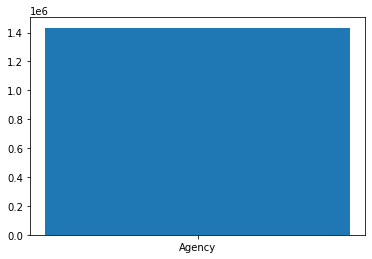

In [106]:
plt.bar(data=num_proj_by_agency, x='Agency', height='count')

Insights: 
- Top 5 agencies by percentage make up vast majority of total % money spent (~75%). In order, these are DOE, SCA, DEP, DOT, HPD
- Biggest spending years are 2023, 2019, 2022, 2020, 2011 in that order
- DOE has spent the most, but only has 1726 checks in the dataset
- By contrast, #2 SCA has spent almost as much, but with 1,433,269 checks
- follow-up: does the average check amount matter for our analysis?

## Step 3: Visualization

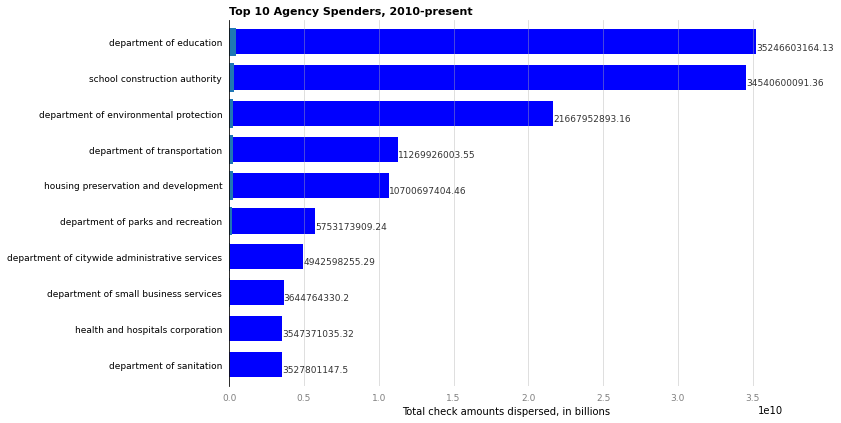

In [94]:
# --- SPENDING BY AGENCY
spending_by_agency = df.groupby('Agency')['Check Amount'].sum().sort_values(ascending=True)

# --- plot --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
spending_by_agency.tail(10).plot(kind='barh', ax=ax, width=0.7, color='blue')

for p in ax.patches:
    ax.annotate( str(p.get_width()), (p.get_width() + 0.75 , p.get_y()+0.075 ), fontsize=9, fontweight='light', alpha = 0.8, color='black', va='bottom')

# tick marks and 0-line
sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Top 10 Agency Spenders, 2010-present", fontsize=11, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("")
ax.set_xlabel("Total check amounts dispersed, in billions")
plt.tight_layout( h_pad=1 )

# change x-tick fonts
for tick in ax.get_xticklabels():
    tick.set_fontsize(9)
    tick.set_color( 'grey' )

# change y-tick fonts
for tick in ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_color( 'black' )

plt.barh(spending_by_agency.index, spending_by_agency)
plt.show()

Insights:
- DOE and SCA are the clear spending leaders, followed by DEP; may prove valuable to focus our exploration/analysis on
- nature of the top 5 agencies implies spending on fixed assets which are likely traceable to location information (schools, roads, waterways, housing)

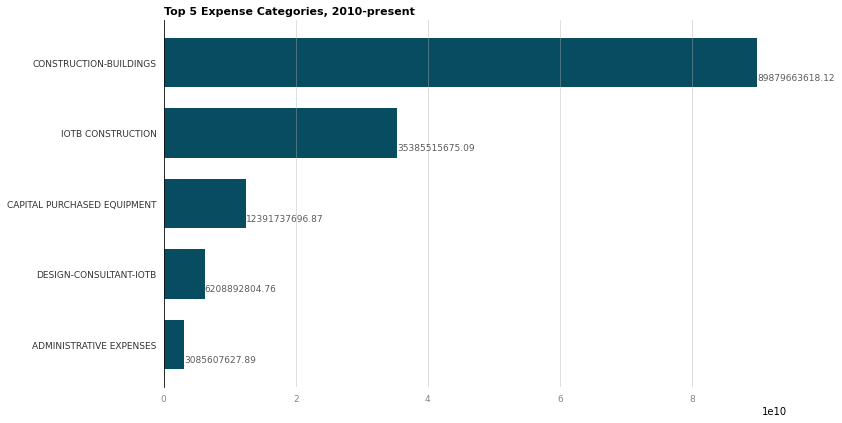

In [ ]:
# --- SPENDING BY EXPENSE CATEGORY

spending_by_exp_cat = df.groupby('Expense Category')['Check Amount'].sum().sort_values(ascending=True)

# --- plot --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
spending_by_exp_cat.tail(5).plot(kind='barh', ax=ax, width=0.7, color='blue')

for p in ax.patches:
    ax.annotate( str(p.get_width()), (p.get_width() + 0.75 , p.get_y()+0.075 ), fontsize=9, fontweight='light', alpha = 0.8, color=black, va='bottom')

sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Top 5 Expense Categories, 2010-present", fontsize=11, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("") # remove y-axis label
plt.tight_layout( h_pad=1 )

for tick in ax.get_xticklabels():
    tick.set_fontsize(9)
    tick.set_color( grey )

for tick in ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_color( black )

plt.barh(spending_by_exp_cat.index, spending_by_exp_cat)
plt.show()

In [107]:
# --- Time series / heat map data

# calculate percentages
total_by_fy = df.groupby('Fiscal year')['Check Amount'].sum()
grouped_data = df.groupby(['Fiscal year', 'Agency'])['Check Amount'].sum().reset_index()

temp_df = grouped_data.copy()
temp_df.loc[:, 'Percent of total check amounts, by FY'] = (temp_df['Check Amount'] / temp_df['Fiscal year'].map(total_by_fy)) * 100

temp_df.head(5)


pct_by_agency_by_fy = temp_df.groupby([pd.Grouper(key = 'Fiscal year'), 'Agency'], as_index = False
).agg({'Percent of total check amounts, by FY':'first', 'Fiscal year':'first'}).sort_values(by = 'Fiscal year', ascending = True)
top_10_pct_by_agency_by_fy = pct_by_agency_by_fy[pct_by_agency_by_fy['Agency'].isin(pct_by_agency_df['Agency'].head(10))]
top_10_pct_by_agency_by_fy['Agency Code'] = pct_by_agency_by_fy['Agency'].map(ag_ac)
#pct_by_agency_by_fy.head(5)



print(top_10_pct_by_agency_by_fy[top_10_pct_by_agency_by_fy['Agency Code']=='DOE'])

                      Agency  Percent of total check amounts, by FY  \
7    department of education                              25.496815   
36   department of education                              19.339766   
64   department of education                              20.552196   
92   department of education                              20.911188   
120  department of education                              21.802320   
148  department of education                              25.655889   
175  department of education                              27.076393   
202  department of education                              25.363379   
229  department of education                              24.302614   
257  department of education                              20.347879   
284  department of education                              22.637473   
311  department of education                              24.095319   
337  department of education                              21.972951   
364  d

/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_15084/380055454.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_pct_by_agency_by_fy['Agency Code'] = pct_by_agency_by_fy['Agency'].map(ag_ac)


/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_15084/1485710716.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = top_10_pct_by_agency_by_fy.pivot('Agency Code', 'Fiscal year', 'Percent of total check amounts, by FY')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


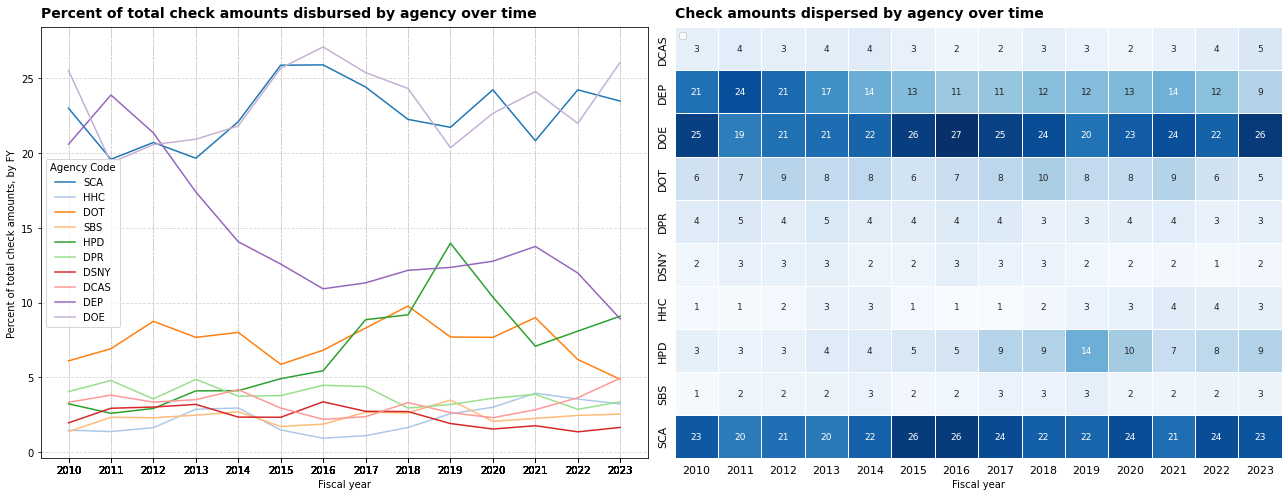

In [ ]:
# --- PLOT
fig,axs = plt.subplots( figsize = (18,7) , ncols = 2 )
# --- time series
ax = axs[0]
sns.lineplot(
    data = top_10_pct_by_agency_by_fy,
    x = 'Fiscal year',
    y = 'Percent of total check amounts, by FY',
    hue = 'Agency Code',
    ax= ax ,
    palette = 'tab20',
)
ax.set_title('Percent of total check amounts disbursed by agency over time', fontsize = 14, fontweight = 'bold', loc = 'left', color = 'black', pad = 10 )
ax.set_xticks(top_10_pct_by_agency_by_fy['Fiscal year'])
ax.set_xticklabels([x.strftime('%Y') for x in top_10_pct_by_agency_by_fy['Fiscal year']],
                   rotation=0, ha='center')
ax.grid(True, color='lightgrey', linestyle='--')

# --- heat map
ax = axs[1]
pivot_data = top_10_pct_by_agency_by_fy.pivot('Agency Code', 'Fiscal year', 'Percent of total check amounts, by FY')
sns.heatmap(
    pivot_data,
    cmap = 'Blues',
    annot = True,
    fmt = '.0f',
    annot_kws = {'fontsize':9},
    cbar = False,
    linewidths = 1,
    linecolor = 'w',
    ax = ax
)
ax.legend( loc = 'upper left', bbox_to_anchor = (0,1), ncol = 1, fontsize = 9 )
ax.set_xticklabels( [ x.strftime('%Y') for x in pivot_data ] , rotation = 0, ha = 'center' )
ax.tick_params( axis = 'both', which = 'both', left = False, bottom = False, labelsize = 11 )
ax.set_ylabel('')
ax.set_title( "Check amounts dispersed by agency over time", fontsize = 14, fontweight = 'bold', loc = 'left', color = 'black' , pad = 10 )

plt.tight_layout( w_pad = 1 )

Notes to improve visual:
- Move legend
- Change colors, overall think about design as a tool for communicating to David/other stakeholders our argument (which I think is that this is feasible... but need to consult with Dea/team on that)
- fix x-ticks on time series

Insights: 
- What was going on with HPD 2016-2020? % total spending has increased significantly over that period and is still higher than before. HPD spends a lot on fixed assets (obviously), so again promising for feasibility.
- DEP was previously 3rd place for spending, and has been trending downward since 2015

## Fuzzy string matching

## Mapping Checkbook NYC Data to existing location data via FacDB

### *Facilities DB*

As stated on the NYC DCP Github site, the [Facilities Database](https://nycplanning.github.io/data-engineering-doc/#/products/facilities?id=compilation-process) "aggregates more than 35,000 records from 52 different public data sources provided by City, State, and Federal agencies." To standardize naming systems, DCP has grouped all facilities into the following seven categories: 
- Health and Human Services
- Education, Child Welfare, and Youth
- Parks, Gardens, and Historical Sites
- Libraries and Cultural Programs
- Public Safety, Emergency Services, and Administration of Justice
- Core Infrastructure and Transportation
- Administration of Government

Each of which is further categorized into sets of facility groups, subgroups and types to make the data more navigatable.

In [47]:
### FACDB
print("Number of rows in FacDB: {} ".format(facdb.shape[0]))
print("Number of cols in FacDB: {} ".format(facdb.shape[1]))
print("List of columns in FacDB: {} ".format(facdb.columns))
print("Number of facility types: {} ".format(len(facdb["factype"].unique())))
print("Number of facility subgroups: {}".format(len(facdb["facsubgrp"].unique())))
print("Number of facility groups: {}".format(len(facdb["facgroup"].unique())))

Number of rows in FacDB: 33429 
Number of cols in FacDB: 38 
List of columns in FacDB: Index(['facname', 'addressnum', 'streetname', 'address', 'city', 'zipcode',
       'boro', 'borocode', 'bin', 'bbl', 'cd', 'nta2010', 'nta2020', 'council',
       'schooldist', 'policeprct', 'ct2010', 'ct2020', 'factype', 'facsubgrp',
       'facgroup', 'facdomain', 'servarea', 'opname', 'opabbrev', 'optype',
       'overagency', 'overabbrev', 'overlevel', 'capacity', 'captype',
       'latitude', 'longitude', 'xcoord', 'ycoord', 'datasource', 'uid',
       'geom'],
      dtype='object') 
Number of facility types: 603 
Number of facility subgroups: 71
Number of facility groups: 25


In [51]:
print("List of facilities groups: {}".format(facdb["facgroup"].unique()))
print("List of facilities subgroups: {}".format(facdb["facsubgrp"].unique()))
print("List of overseeing agencies: {}".format(facdb["overagency"].unique()))

List of facilities groups: ['CHILD SERVICES AND WELFARE' 'YOUTH SERVICES'
 'DAY CARE AND PRE-KINDERGARTEN' 'HUMAN SERVICES' 'CAMPS' 'HEALTH CARE'
 'ADULT SERVICES' 'JUSTICE AND CORRECTIONS' 'HISTORICAL SITES'
 'TRANSPORTATION' 'VOCATIONAL AND PROPRIETARY SCHOOLS' 'PARKS AND PLAZAS'
 'CULTURAL INSTITUTIONS' 'SOLID WASTE' 'SCHOOLS (K-12)' 'LIBRARIES'
 'PUBLIC SAFETY' 'OFFICES, TRAINING, AND TESTING' 'HIGHER EDUCATION'
 'CITY AGENCY PARKING, MAINTENANCE, AND STORAGE' 'WATER AND WASTEWATER'
 'EMERGENCY SERVICES' 'MATERIAL SUPPLIES AND MARKETS' 'OTHER PROPERTY'
 'TELECOMMUNICATIONS']
List of facilities subgroups: ['CHILD NUTRITION'
 'YOUTH CENTERS, LITERACY PROGRAMS, AND JOB TRAINING SERVICES' 'DAY CARE'
 'LEGAL AND INTERVENTION SERVICES' 'CAMPS'
 'NON-RESIDENTIAL HOUSING AND HOMELESS SERVICES'
 'SUBSTANCE USE DISORDER TREATMENT PROGRAMS'
 'ADULT AND IMMIGRANT LITERACY' 'DETENTION AND CORRECTIONAL'
 'AFTER-SCHOOL PROGRAMS' 'SOUP KITCHENS AND FOOD PANTRIES'
 'COMMUNITY CENTERS AND COMMUNITY 

**Facilities groups** to try matching for DOE/SCA:
- 'DAY CARE AND PRE-KINDERGARTEN'
- 'YOUTH SERVICES'
- 'CAMPS'
- 'VOCATIONAL AND PROPRIETARY SCHOOLS'
- 'SCHOOLS (K-12)'
- 'LIBRARIES'
- 'HIGHER EDUCATION'

**Facilities subgroups** for DOE/SCA: 
- 'AFTER-SCHOOL PROGRAMS'
- 'PROPRIETARY SCHOOLS'
- 'CHARTER K-12 SCHOOLS'
- 'PUBLIC K-12 SCHOOLS'
- 'NON-PUBLIC K-12 SCHOOLS'
-  'PUBLIC AND PRIVATE SPECIAL EDUCATION SCHOOLS'
-  'GED AND ALTERNATIVE HIGH SCHOOL EQUIVALENCY'
-  'PRESCHOOLS FOR STUDENTS WITH DISABILITIES'
- 'HEAD START'
-  'COLLEGES OR UNIVERSITIES'
-  'DOE UNIVERSAL PRE-KINDERGARTEN'

**Overseeing agencies** that match to DOE / SCA: 
- 'NYC Department of Education'

In [116]:
### --- filter FacDB dataset for facilities relating to DOE / SCA 
overagency = ['NYC Department of Education']
facgroup = ['DAY CARE AND PRE-KINDERGARTEN', 'YOUTH SERVICES', 'CAMPS', 'VOCATIONAL AND PROPRIETARY SCHOOLS', 'SCHOOLS (K-12)', 'LIBRARIES', 'HIGHER EDUCATION']
facsubgrp = ['AFTER-SCHOOL PROGRAMS', 'PROPRIETARY SCHOOLS', 'CHARTER K-12 SCHOOLS', 'PUBLIC K-12 SCHOOLS', 'NON-PUBLIC K-12 SCHOOLS', 
'PUBLIC AND PRIVATE SPECIAL EDUCATION SCHOOLS', 'GED AND ALTERNATIVE HIGH SCHOOL EQUIVALENCY', 'PRESCHOOLS FOR STUDENTS WITH DISABILITIES', 
'HEAD START', 'COLLEGES OR UNIVERSITIES', 'DOE UNIVERSAL PRE-KINDERGARTEN']
facdomain = ['EDUCATION, CHILD WELFARE, AND YOUTH']

doe_facdb = facdb[['facname', 'address']][(facdb['overagency'].isin(overagency)) \
     | (facdb['facgroup'].isin(facgroup)) \
     | (facdb['facsubgrp'].isin(facsubgrp)) \
     | (facdb['facdomain'].isin(facdomain))]

print("There are {} rows in the facilities database pertaining to DOE-overseen or education-related programs and facilities.".format(doe_facdb.shape[0]))

There are 15684 rows in the facilities database pertaining to DOE-overseen or education-related programs and facilities.


In [118]:
doe_df = df[(df['Agency']=='department of education') | (df['Agency']=='school construction authority')]
print("There are {} rows in the Checkbook NYC dataset where 'Agency' == 'DOE' or 'SCA.".format(doe_df.shape[0]))

doe_df = doe_df[['Associated Prime Vendor', 'Budget Code', 'Capital Project',
       'Check Amount']]

There are 1434995 rows in the Checkbook NYC dataset where 'Agency' == 'DOE' or 'SCA.


### *Overview of methods for adding spatial data to projects*

For this project, we explored matching spatial data from the Facilities DB to the Checkbook NYC dataset using **approximate (or fuzzy) string matching**. This is a method of finding strings that match a pattern approximately (rather than exactly). 

First, I limited the scope of both datasets by filtering for rows that pertained to the DOE (Checkbook) or education-related facilities (FacDB). For the latter, I manually read through the unique facilities groups/subgroups/overseeing agencies to create a list of education-related field values. Then, I tried using fuzzy string matching using `thefuzz` python package on the facility names to find matches between the two datasets, using the `'facname'` column from `facdb` and the `'Budget Code'` column from `df`.



In [85]:
# partial fuzzy string matching
### TODO: verify correctness
doe_df_budget = df['Budget Code']
doe_facdb_facnames = doe_facdb['facname']

print("--- Fuzzy string matching outcomes, facility names from FacDB against DOE project budget codes from Checkbook NYC --- ")
print("Token sort ratio: {} ".format(fuzz.token_sort_ratio(doe_df_budget, doe_facdb_facnames)))
print("Token set ratio: {} ".format(fuzz.token_set_ratio(doe_df_budget, doe_facdb_facnames)))
print("Partial token sort ratio: {}".format(fuzz.partial_token_sort_ratio(doe_df_budget, doe_facdb_facnames)))

--- Fuzzy string matching outcomes, facility names from FacDB against DOE project budget codes from Checkbook NYC --- 
Token sort ratio: 41 
Token set ratio: 49 
Partial token sort ratio: 41


In [120]:
# fuzzymatcher record linkage 

df_joined = fuzzymatcher.fuzzy_left_join(doe_df, doe_facdb, left_on = "Budget Code", right_on="facname")
num_records = len(df_joined)
correct_binary = (df_joined["facname"] == df_joined["Budget Code"])
perc_correct = correct_binary.sum()/num_records

print(perc_correct)

In [ ]:
#  --- fuzzy string matching test
fixed_assets = pd.Series(open('fixed_assets.txt', 'r').read().splitlines())

df['Fixed Asset Match'] = 0

filtered_df = df[df['Agency']=='department of education']
filtered_df.reset_index(drop=True, inplace=True)

# --- how to do this for a BIG dataset... 
for asset in fixed_assets:
    mask = ~filtered_df['Budget Code'].isna()
    filtered_df.loc[mask, 'Fixed Asset Match'] += filtered_df.loc[mask, 'Budget Code'].apply(lambda x: fuzz.partial_ratio(asset, x) > 70)

# Calculate the percentage of matches
total_rows = len(filtered_df)
num_matches = filtered_df['Fixed Asset Match'].sum()
percentage_of_matches = (num_matches / total_rows) * 100

print("Percentage of DOE Budget Codes that reference fixed assets, threshold 70: {}".format(percentage_of_matches))

KeyError: 'Agency Code'